In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

from utils import NMF, plot_nmf_components, plot_reconstructed_images

In [2]:
n = 100 # n samples
m = 25 # m features
r = 20

np.random.seed(0)
X = np.abs(np.random.randn(n,m))

# Apply NMF
model = NMF(n_components=r, max_iter=1000, random_state=42, verbose=True)
W = model.fit_transform(X)
H = model.H

# Check reconstruction
X_reconstructed = model.inverse_transform() # W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nFinal reconstruction error: {error:.4f}")

Iteration 100/1000, error: 11.7286
Iteration 200/1000, error: 10.7836
Iteration 300/1000, error: 10.4503
Iteration 400/1000, error: 10.2828
Iteration 500/1000, error: 10.2079
Iteration 600/1000, error: 10.1766
Iteration 700/1000, error: 10.1583
Iteration 800/1000, error: 10.1445
Iteration 900/1000, error: 10.1375
Iteration 1000/1000, error: 10.1333

Final reconstruction error: 10.1333


## NMS for Facial Feature Extraction

In [3]:
# Load LFW dataset
faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
images = faces.images  # shape (n_samples, height, width)

h, w = images.shape[1:]
X = faces.data.T  # shape (n_features, n_samples)

print(f"Images shape: (h,w)=({h},{w})")
print(f"Dataset shape: (n,m)={X.shape}")

Images shape: (h,w)=(50,37)
Dataset shape: (n,m)=(1850, 1288)


In [4]:
r = 150

model = NMF(
    n_components=r,
    max_iter=2000,
    random_state=42,
    verbose=True
)
W = model.fit_transform(X)
H = model.H

# Check reconstruction
X_reconstructed = model.inverse_transform() # W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nFinal reconstruction error: {error:.4f}")

Iteration 100/2000, error: 120.5240
Iteration 200/2000, error: 94.0110
Iteration 300/2000, error: 83.8928
Iteration 400/2000, error: 78.7397
Iteration 500/2000, error: 75.6932
Iteration 600/2000, error: 73.7140
Iteration 700/2000, error: 72.3419
Iteration 800/2000, error: 71.3386
Iteration 900/2000, error: 70.5728
Iteration 1000/2000, error: 69.9661
Iteration 1100/2000, error: 69.4731
Iteration 1200/2000, error: 69.0625
Iteration 1300/2000, error: 68.7149
Iteration 1400/2000, error: 68.4149
Iteration 1500/2000, error: 68.1518
Iteration 1600/2000, error: 67.9201
Iteration 1700/2000, error: 67.7133
Iteration 1800/2000, error: 67.5269
Iteration 1900/2000, error: 67.3576
Iteration 2000/2000, error: 67.2013

Final reconstruction error: 67.2013


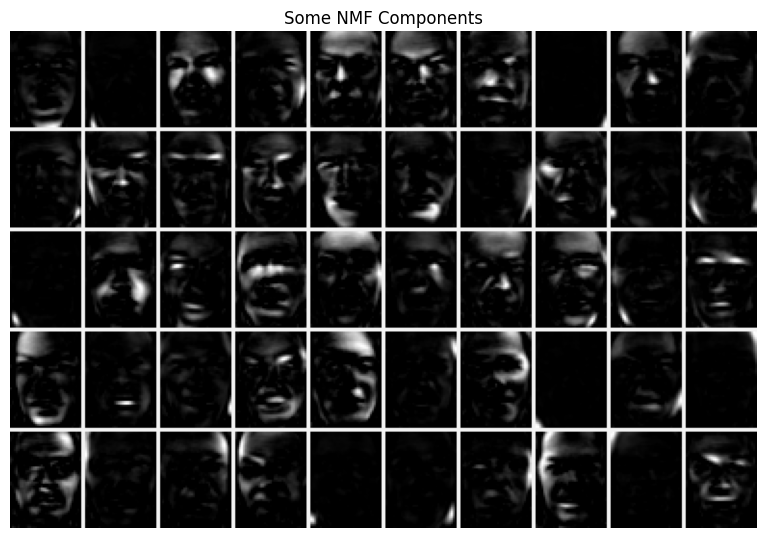

In [5]:
plot_nmf_components(
    W, image_shape=(50, 37), 
    n_components=50, n_cols=10, 
    title="Some NMF Components"
)

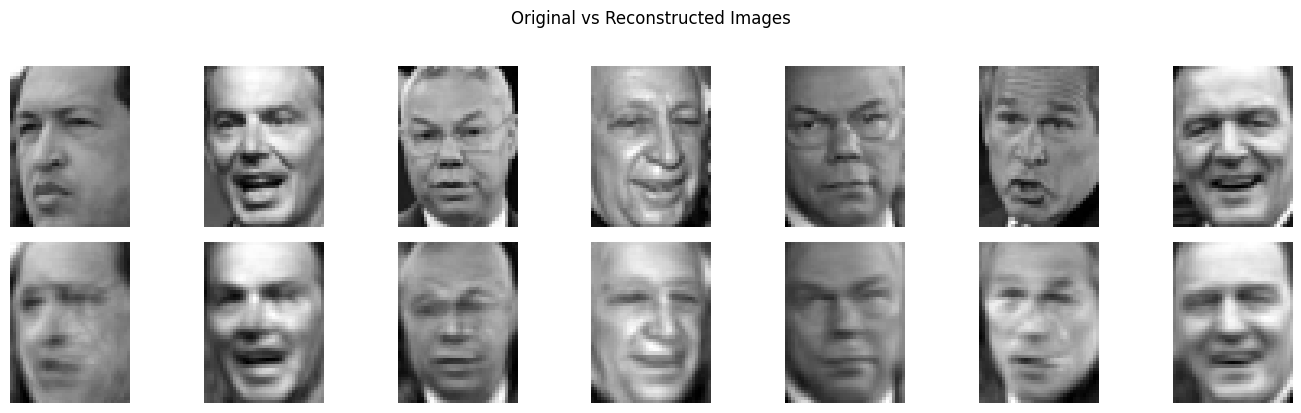

In [6]:
plot_reconstructed_images(
    X, X_reconstructed,
    image_shape=(50, 37),
    indices=[0,1,3,4,5,6,7],
    n_cols=7
)